# Implementation of AB Testing in Cafe Rewards

## A. Introduction & Background

### Challenge Objective

You've just run a test by sending different combinations of promotional offers to existing rewards members. Now that the 30-day period for the test has concluded, your task is to identify key customer segments and develop a data-driven strategy for future promotional messaging & targeting.

The results need to be summarized in a report that will be presented to the CMO

Data that simulates the behavior of Cafe Rewards members over a 30-day period, including their transactions and responses to promotional offers. The data is contained in three files: one with details on each offer, another with demographic information on each customer, and a third with the activity for each customer during the period. The activities are divided into offer received, offer viewed, offer accepted, and transaction. For a transaction to be attributed to an offer, it must occur at the same time as when the offer was "completed" by the customer.

## B. Import Library 

In [136]:
pip install pyodbc

Note: you may need to restart the kernel to use updated packages.


In [137]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [138]:
import pyodbc as pyodbc
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import seaborn as sns
import scipy
from scipy import stats
import scipy.stats as st
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep


- pyodbc:

>Fungsi: Digunakan untuk menghubungkan Python ke database menggunakan ODBC (Open Database Connectivity). pyodbc memungkinkan kamu menjalankan query SQL langsung dari Python.

- pandas:
    
>Fungsi: Library utama untuk manipulasi dan analisis data. pandas memungkinkan pengelolaan data dalam bentuk DataFrame yang mudah digunakan untuk pembersihan data, agregasi, dan operasi statistik.

- sqlalchemy:
    
>Fungsi: Sebuah toolkit dan ORM (Object-Relational Mapping) untuk Python. sqlalchemy digunakan untuk menghubungkan Python ke database dengan lebih mudah, membuat query SQL, dan mengelola transaksi.

- numpy:
    
>Fungsi: Library untuk komputasi numerik. numpy digunakan untuk operasi matematika pada array dan matriks, serta manipulasi data yang lebih efisien.

- seaborn:
    
>Fungsi: Library visualisasi data berbasis matplotlib. seaborn membuat pembuatan plot yang lebih estetik dan mudah untuk analisis statistik seperti scatter plots, histograms, dan heatmaps.

- scipy.stats:

>Fungsi: Bagian dari library scipy yang menyediakan berbagai fungsi statistik seperti uji hipotesis, distribusi probabilitas, serta pengukuran statistika lainnya.

- scipy.stats.chisquare:

>Fungsi: Melakukan uji chi-square, digunakan untuk membandingkan distribusi data yang diobservasi dengan distribusi yang diharapkan dalam statistik non-parametrik.

- statsmodels.stats.power.TTestIndPower:

>Fungsi: Digunakan untuk menghitung "power" statistik dalam uji T. Power analysis membantu menentukan ukuran sampel yang diperlukan untuk uji hipotesis yang efektif.

- matplotlib.pyplot:

>Fungsi: Library untuk visualisasi data. matplotlib.pyplot menyediakan alat untuk membuat grafik dasar seperti bar charts, line charts, scatter plots, dan histogram.

- statsmodels.stats.proportion.proportions_ztest:

>Fungsi: Melakukan uji Z pada proporsi, digunakan untuk menguji apakah ada perbedaan signifikan antara dua proporsi dalam uji hipotesis.

- statsmodels.stats.proportion.confint_proportions_2indep:

>Fungsi: Menghitung interval kepercayaan (confidence interval) untuk perbandingan dua proporsi independen.

## C. Setting Up Problem

### Experimental Goal

Tujuan eksperimen ini adalah menguji Offer yang diberikan untuk menentukan Offer mana yang lebih efektif. secara spesifik, tujuanya adalah untuk mengidentifikasi Offer mana yang paling banyak digunakan dan pada akhirnya dapat meningkatkan jumlah pengguna yang loyal dengan Offer yang diberikan

untuk mencapai tujuan ini, eksperimen dirancang untuk membandingkan dua atau lebih versi dari Offer Type yang sama, dimana satu versi menampilkan jumlah Reward, Difficult, Duration yang berbeda. Eksperimen kemudian dapat mengukur efektivtas masing masing offer yang diberikan dimana tujuan utamanya adalah untuk menentukan offer yang mana yang dapat membuat customer dapat menjadi loyal dan menggunakan informasi tersebut untuk menjadi acuan dalam pemberian Offer di masa mendatang

### Choosing Metrics

Untuk merumuskan metrik eksperimen, ada beberapa langkah yang perlu dilakukan. Pertama, kita harus menetapkan tujuan dari eksperimen tersebut. Selanjutnya, kita perlu mengidentifikasi cara untuk mencapai tujuan tersebut. Dari tujuan dan pendekatan yang telah ditentukan, kita dapat menentukan hasil yang diharapkan. Setelah itu, kita bisa mengidentifikasi Metrik Penggerak (Driver Metrics) dan Metrik Pengawal (Guardrail Metrics).

Metrik Penggerak harus sejalan dengan metrik tujuan, peka, dapat ditindaklanjuti, dan relevan dalam konteks eksperimen jangka pendek. Karakteristik ini menjadikan metrik tersebut sesuai untuk eksperimen. Sementara itu, Metrik Pengawal berfungsi untuk memberikan peringatan terkait hasil eksperimen yang mungkin menyesatkan. Metrik ini memantau potensi terjadinya trade-off yang tidak diinginkan dan dapat digunakan untuk memverifikasi keandalan hasil eksperimen. Terdapat dua jenis Metrik Pengawal:

**a. Metrik Pengawal Organisasi**

- Metrik ini mengidentifikasi apakah ada trade-off lain yang muncul saat melaksanakan inisiatif.
- Jika metrik ini menunjukkan dampak negatif, perusahaan berpotensi mengalami kerugian.

**b. Metrik Pengawal Kepercayaan (Trust-Related Guardrail Metrics)**

- Metrik ini memantau tingkat kepercayaan (trustworthiness) dari eksperimen.
- Metrik ini juga berfungsi untuk memeriksa pelanggaran terhadap asumsi yang ada.

Berdasarkan aspek-aspek tersebut, penulis menentukan semua metrik yang diperlukan untuk eksperimen ini. Berikut adalah hasil penentuan metriknya.

Conversion Rate digunakan sebagai metrik dalam analisis multivariat karena mewakili tujuan utama bisnis, seperti penjualan, dan memberikan ukuran langsung tentang efektivitas Offer. Metrik ini terukur, objektif, serta sensitif terhadap perubahan, sehingga memungkinkan deteksi perbedaan kecil antara variasi yang diuji. Selain itu, Conversion Rate memberikan hasil yang cepat, memudahkan perbandingan antara variasi, dan memungkinkan optimasi langsung berdasarkan kinerja terbaik. Karena itu, Conversion Rate menjadi pilihan ideal untuk menganalisis efektivitas berbagai kombinasi perlakuan dalam eksperimen jangka pendek.

- BOGO : 
            A.	Dif = 10 , Reward = 10 , Duration = 7, Channe = Email,Mobile,Sosial
            B.	Dif = 10 ,  Reward = 10 , Duration = 5, Channe = Web,Email,Mobile,Sosial
            C.	Dif = 5 , Reward = 5 , Duration = 7, Channe = Web,Email,Mobile
            D.	Dif = 5 , Reward = 5 , Duration = 6, Channe = Web,Email,Mobile,Sosial

### Hypothesis

Hipotesa dari tiap group sebagai berikut :

- group 1 vs group 2
    $$H_0 : p_B \leq p_A$$
    $$H_1 : p_B > p_A$$

- group 1 vs group 3
    $$H_0 : p_C \leq p_A$$
    $$H_1 : p_C > p_A$$

- group 1 vs group 4
    $$H_0 : p_D \leq p_A$$
    $$H_1 : p_D > p_A$$

- group 2 vs group 3
    $$H_0 : p_C \leq p_B$$
    $$H_1 : p_C > p_B$$

- group 2 vs group 4
    $$H_0 : p_D \leq p_B$$
    $$H_1 : p_D > p_B$$

- group 3 vs group 4
    $$H_0 : p_D \leq p_C$$
    $$H_1 : p_D > p_C$$
    

### Designing Experiments

#### •	Randomization Unit

Unit randomisasi adalah “siapa” atau “apa” yang secara acak dialokasikan ke setiap kelompok. Untuk mendapatkan konteks lebih spesifik dari eksperimen, kami membatasi populasi pada orang-orang yang berada di Jakarta.

#### •	Target of randomization unit

Unit randomisasi yang ditargetkan adalah semua pengguna yang terpapar oleh Offer. Selain itu, kami juga mempertimbangkan DIfficult, Reward, Duration dan Channel sebagai variasi 

#### •	Sample size

Ukuran sampel akan mempengaruhi kekuatan bukti untuk menunjukkan validitas eksperimen.

**Tingkat Signifikansi (α)**
α = P (Menerima H1 | Ho benar)
Ini berarti peluang menerima H1, padahal Ho sebenarnya benar. Karena hal ini merupakan kesalahan, nilai α harus dikurangi. Secara konservatif, industri biasanya menggunakan 5% atau 1% untuk nilai α. Kami memutuskan menggunakan α = 5% sebagai tingkat signifikansi.

**Tingkat Kekuatan (1 - β)**
1 - β = P (Menolak Ho | Ho salah)
Ini berarti peluang menolak Ho, padahal Ho sebenarnya salah. Karena hal ini benar, nilai 1 - β harus ditingkatkan. Secara konservatif, industri menggunakan 80% sebagai tingkat kekuatan. Kami memutuskan menggunakan 1 - β = 80% sebagai tingkat kekuatan.

**Standar Deviasi Populasi (σ)**
Untuk eksperimen ini, kami mengasumsikan standar deviasi populasi sebesar 0,2.

**Perbedaan antara Kontrol dan Perlakuan (δ)**
Untuk tujuan bisnis, kami berasumsi bahwa perlakuan ini akan menguntungkan jika rasio konversi meningkat sebesar 1%. Dengan demikian, manajemen akan lebih memilih mengimplementasikan Creative Ads dibandingkan PSA karena dampaknya terhadap peningkatan rasio konversi.

#### • Calculating Sample Size

#### Berapa ukuran sampel minimum yang diperlukan ketika $\alpha=5 \%$ dan pangkat 80% ?

- Ingat, kita dapat memanfaatkan rumus yang tersedia untuk menghitung jumlah sampel minimum yang diperlukan.

$$
n = \cfrac{2 \sigma^2 (z_{1-\alpha/2}+z_{1-\beta})^2}{\delta^2}
$$

- Oleh karena itu, jika kita mengetahui nilai $z$, kita dapat menghitung jumlah sampel yang dibutuhkan.


- Dalam hal ini, kita tidak mengetahui deviasi standar dari tingkat konversi.
- Namun, kita dapat menghitung deviasi standar dengan informasi tentang tingkat konversi dasar saat ini.
- Peristiwa konversi dianggap sebagai percobaan Bernoulli, dengan $\hat{p}=0.04$
- Kita dapat menghitung deviasi standar dengan menggunakan rumus berikut yang berbasis pada distribusi Bernoulli:

$$\sigma=\sqrt{\hat{p}(1-\hat{p})}$$

- Penggunaan distribusi Bernoulli dalam konteks konversi karena:

>Dua Hasil: Percobaan Bernoulli hanya memiliki dua hasil yang mungkin: keberhasilan (misalnya, konversi) dan kegagalan (tidak konversi). Ini sesuai dengan banyak situasi dalam analisis konversi, di mana kita melihat apakah pengguna melakukan tindakan tertentu atau tidak.

In [139]:
# calculate standar deviation
import numpy as np
#given 
p=0.04

std_dev = np.sqrt(p*(1-p))
std_dev

0.19595917942265423

In [140]:
# Given
delta = 0.01        
alpha = 0.05        
power = 0.8         
   

In [141]:
# calculate beta
beta = 1 - power
beta

0.19999999999999996

In [142]:
# calculate the z value
z_alpha = stats.norm.ppf(1 - alpha/2)
z_beta = stats.norm.ppf(1 - beta)

z_alpha, z_beta

(1.959963984540054, 0.8416212335729143)

In [143]:
# then calculate the number of sample size
n = 2 * (std_dev**2) * ((z_alpha+z_beta)**2) / (delta**2)

print(f"Number of sample size needed    : {n:.0f}")

Number of sample size needed    : 6028


**In conclusion**
- We need 6028 samples in one group

## D.Import Data From SQL Server 

In [144]:
connection_string = 'mssql+pyodbc://DESKTOP-KOO9GIJ\\MSSQLSERVER01/ads?driver=ODBC+Driver+17+for+SQL+Server'

engine = create_engine(connection_string)

In [145]:
query = ''' 
WITH ranked_offers AS (
    SELECT 
        [offer],
        [customer_id],
        [event],
        [time],
        [Amount],
        [OfferId],
        [offer_type],
        [duration],
        ROW_NUMBER() OVER (PARTITION BY [customer_id], [OfferId] ORDER BY [time]) AS offer_sequence
    FROM [ads].[dbo].[new_data]
    WHERE [event] = 'offer received'
)
, cc as (
SELECT 
    CASE 
        WHEN nd.[event] = 'offer received' 
        THEN CONCAT(nd.[OfferId], '_', ro.offer_sequence) 
        ELSE nd.[OfferId] 
    END AS final_offer_id
	,nd.*
FROM [ads].[dbo].[new_data] nd
LEFT JOIN ranked_offers ro
    ON nd.[customer_id] = ro.[customer_id] 
    AND nd.[OfferId] = ro.[OfferId]
    AND nd.[time] = ro.[time]
	)
,r as  ( 
    SELECT 
		CONCAT(customer_id, '_', OfferId, '_', CAST(time AS VARCHAR)) AS new_id,
        OfferId,
        customer_id
    FROM 
        cc
    WHERE 
         event = 'offer completed' or offer = 'Transaction With Offer' or offer_type = 'informational'
)
,c as ( 
SELECT 
	CONCAT(customer_id, '_', OfferId, '_', CAST(time AS VARCHAR)) AS new_id,
	case when event = 'transaction' then time else null end as time_transaction,
    nd.*
FROM 
    cc AS nd
	where event != 'offer viewed' 
), dc as 
( 
select c.* from c
where   
     NOT EXISTS (
        SELECT 1
        FROM r 
        WHERE 
		(r.customer_id = c.customer_id AND r.OfferId = c.OfferId)  

    )  

), kk as (
select dc.* from dc
where NOT EXISTS ( SELECT 1 FROM r WHERE r.new_id = dc.new_id  ) 


)
, gabung as (
select 
[offer]
      ,[customer_id]
      ,[event]
      ,[time]
      ,[Amount]
      ,[OfferId]
      ,[reward_get]
      ,[Tahun]
      ,[Bulan]
      ,[Tanggal]
      ,[became_member_on]
      ,[gender]
      ,[age]
      ,[income]
      ,[offer_type]
from kk
where event = 'offer received'
union all 
SELECT 
		[offer]
      ,[customer_id]
      ,[event]
      ,[time]
      ,[Amount]
      ,[OfferId]
      ,[reward_get]
      ,[Tahun]
      ,[Bulan]
      ,[Tanggal]
      ,[became_member_on]
      ,[gender]
      ,[age]
      ,[income]
      ,[offer_type]
  FROM [ads].[dbo].[new_data]
  where offer = 'Transaction With Offer' 
  )
  select 
  g.*, ofs.[difficulty]
      ,ofs.[reward]
      ,ofs.[duration]
      ,ofs.[channels]
	  , CASE 
        WHEN [OfferId] ='ae264e3637204a6fb9bb56bc8210ddfd' THEN 'A'
        WHEN [OfferId] = '4d5c57ea9a6940dd891ad53e9dbe8da0' THEN 'B'
        WHEN [OfferId] = '9b98b8c7a33c4b65b9aebfe6a799e6d9'THEN 'C'
        WHEN [OfferId] = 'f19421c1d4aa40978ebb69ca19b0e20d' THEN 'D'
        WHEN [OfferId] = '0b1e1539f2cc45b7b9fa7c272da2e1d7' THEN 'E'
        WHEN [OfferId] = '2298d6c36e964ae4a3e7e9706d1fb8c2' THEN 'F'
        WHEN [OfferId] =  'fafdcd668e3743c1bb461111dcafc2a4'THEN 'G'
        WHEN [OfferId] = '2906b810c7d4411798c6938adc9daaa5' THEN 'H'
        ELSE 'Unknown Group'
    END AS groups
    ,case when g.offer = 'Offer' then 0 else 1 end conver
  from gabung as g
  inner join [ads].[dbo].[offers] as ofs
  on g.[OfferId] = ofs.[offer_id]
  '''

In [146]:
# Eksekusi query menggunakan pandas
df = pd.read_sql(query, engine)
df

,offer,customer_id,event,time,Amount,OfferId,reward_get,Tahun,Bulan,Tanggal,...,gender,age,income,offer_type,difficulty,reward,duration,channels,groups,conver
0,Offer,00116118485d4dfda04fdbaba9a87b5c,offer received,168.0,,f19421c1d4aa40978ebb69ca19b0e20d,None,2018,04,25,...,None,118.0,NaN,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
1,Offer,00116118485d4dfda04fdbaba9a87b5c,offer received,576.0,,f19421c1d4aa40978ebb69ca19b0e20d,None,2018,04,25,...,None,118.0,NaN,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
2,Offer,0020c2b971eb4e9188eac86d93036a77,offer received,168.0,,ae264e3637204a6fb9bb56bc8210ddfd,None,2016,03,04,...,F,59.0,90000.0,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
3,Offer,00426fe3ffde4c6b9cb9ad6d077a13ea,offer received,336.0,,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,2016,08,09,...,F,19.0,65000.0,discount,20.0,5.0,10.0,"['web', 'email']",E,0
4,Offer,00426fe3ffde4c6b9cb9ad6d077a13ea,offer received,576.0,,2906b810c7d4411798c6938adc9daaa5,None,2016,08,09,...,F,19.0,65000.0,discount,10.0,2.0,7.0,"['web', 'email', 'mobile']",H,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54951,Transaction With Offer,ffdefcac307f4ca99ac1ebd51470f106,transaction,54.0,24.41,fafdcd668e3743c1bb461111dcafc2a4,None,2017,03,15,...,F,87.0,47000.0,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1
54952,Transaction With Offer,fff3ba4757bd42088c044ca26d73817a,transaction,6.0,20.98,fafdcd668e3743c1bb461111dcafc2a4,None,2015,09,20,...,F,69.0,83000.0,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1
54953,Transaction With Offer,fff7576017104bcc8677a8d63322b5e1,transaction,192.0,5.99,fafdcd668e3743c1bb461111dcafc2a4,None,2017,10,31,...,M,71.0,73000.0,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1
54954,Transaction With Offer,fff7576017104bcc8677a8d63322b5e1,transaction,594.0,8.01,fafdcd668e3743c1bb461111dcafc2a4,None,2017,10,31,...,M,71.0,73000.0,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1


In [147]:
# Seleksi kolom tertentu dari DataFrame
df = df[['customer_id', 'OfferId','offer_type', 'difficulty', 'reward', 'duration', 'channels','groups', 'conver']]

# Tampilkan hasil
df


,customer_id,OfferId,offer_type,difficulty,reward,duration,channels,groups,conver
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
2,0020c2b971eb4e9188eac86d93036a77,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
3,00426fe3ffde4c6b9cb9ad6d077a13ea,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20.0,5.0,10.0,"['web', 'email']",E,0
4,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,discount,10.0,2.0,7.0,"['web', 'email', 'mobile']",H,0
...,...,...,...,...,...,...,...,...,...
54951,ffdefcac307f4ca99ac1ebd51470f106,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1
54952,fff3ba4757bd42088c044ca26d73817a,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1
54953,fff7576017104bcc8677a8d63322b5e1,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1
54954,fff7576017104bcc8677a8d63322b5e1,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1


In [148]:
bogo_df = df[df['offer_type'] == 'bogo']
bogo_df

,customer_id,OfferId,offer_type,difficulty,reward,duration,channels,groups,conver
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
2,0020c2b971eb4e9188eac86d93036a77,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
7,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
8,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
...,...,...,...,...,...,...,...,...,...
50138,ffb7fc8ad0594248a49e210ff0217c2d,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1
50139,ffb7fc8ad0594248a49e210ff0217c2d,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1
50140,fff29fb549084123bd046dbc5ceb4faa,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1
50141,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1


In [149]:
#bogo_df["groups"] = bogo_df["groups"].replace({"E": "A", "F": "B", "G": "C", "H": "D"})

- dilakukan transform perubaha group agar lebih mudah menggunakan code code sebelumnya dipakai dalam mencari BOGO

In [150]:
bogo_df[[ 'OfferId','offer_type', 'difficulty', 'reward', 'duration', 'channels','groups', ]].drop_duplicates().sort_values(by='groups')


,OfferId,offer_type,difficulty,reward,duration,channels,groups
2,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A
17,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,10.0,5.0,"['web', 'email', 'mobile', 'social']",B
12,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",C
0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D


## E.Exploratory Data Analysis

### Informasi Dasar

In [151]:
bogo_df.head()

,customer_id,OfferId,offer_type,difficulty,reward,duration,channels,groups,conver
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
2,0020c2b971eb4e9188eac86d93036a77,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
7,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
8,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0


In [152]:
bogo_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27406 entries, 0 to 50142
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  27406 non-null  object 
 1   OfferId      27406 non-null  object 
 2   offer_type   27406 non-null  object 
 3   difficulty   27406 non-null  float64
 4   reward       27406 non-null  float64
 5   duration     27406 non-null  float64
 6   channels     27406 non-null  object 
 7   groups       27406 non-null  object 
 8   conver       27406 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 2.1+ MB


In [153]:
bogo_df.groupby(['OfferId', 'offer_type']).size().reset_index(name='total_rows').sort_values(by=['offer_type'])

,OfferId,offer_type,total_rows
0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,6927
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,6825
2,ae264e3637204a6fb9bb56bc8210ddfd,bogo,6976
3,f19421c1d4aa40978ebb69ca19b0e20d,bogo,6678


- Seluruh data sudah bersih dan tidak ditemukannya null atau data type yang salah pada tiap kolom 
- tidak diperlukannya pengecekan data distribusi dikarenakan dalam mencari multivariate testing ini yang digunakan adalah convert,namun jika yang digunakan amount atau revenue maka diperlukan yang namanya transformasi agar distribusi menjadi normal agar data menjadi lebih valid
- tidak dilakukan drop duplicate dikarenakan dalam pemberian offer pada waktu 1 bulan dapat diberikan 1 atau lebih offer 

## F. Mengimplementasikan Eksperimen 

In [154]:
data_A = bogo_df[bogo_df['groups'] == 'A']
data_B = bogo_df[bogo_df['groups'] == 'B']
data_C = bogo_df[bogo_df['groups'] == 'C']
data_D = bogo_df[bogo_df['groups'] == 'D']

In [155]:
data_A = data_A.sample(n=6280, random_state=10) 
data_B = data_B.sample(n=6280, random_state=10)
data_C = data_C.sample(n=6280, random_state=10)
data_D = data_D.sample(n=6280, random_state=10)

In [156]:
bogo_df = bogo_df[['OfferId', 'groups']].drop_duplicates().sort_values(by='groups')
bogo_df

,OfferId,groups
2,ae264e3637204a6fb9bb56bc8210ddfd,A
17,4d5c57ea9a6940dd891ad53e9dbe8da0,B
12,9b98b8c7a33c4b65b9aebfe6a799e6d9,C
0,f19421c1d4aa40978ebb69ca19b0e20d,D


- Mencari **#user** dalam group

In [157]:
# Count users in group A, B, C, D
n_A = data_A.shape[0]
n_B = data_B.shape[0]
n_C = data_C.shape[0]
n_D = data_D.shape[0]
print(n_D)

6280


In [158]:
# group A
n_convertA = data_A['conver'].sum()
print(n_convertA)
# group B
n_convertB = data_B['conver'].sum()
print(n_convertB)
# group C
n_convertC = data_C['conver'].sum()
print(n_convertC)
# group D
n_convertD = data_D['conver'].sum()
print(n_convertD)

2916
2638
3551
3565


In [159]:
cr_A = n_convertA/n_A
cr_B = n_convertB/n_B
cr_C = n_convertC/n_C
cr_D = n_convertD/n_D

print(f"convertion rate A : {cr_A:.2f}")
print(f"convertion rate B : {cr_B:.2f}")
print(f"convertion rate C : {cr_C:.2f}")
print(f"convertion rate D : {cr_D:.2f}")

convertion rate A : 0.46
convertion rate B : 0.42
convertion rate C : 0.57
convertion rate D : 0.57


Setelah kita mengetahui conversion rate dari tiap group maka kita buat table agar lebih mudah dalam membacanya!

<center>

|Group|#User|#Convert|Convertion Rate
|:--|:--:|:--:|:--:|
|A|6280|2916|0.46|
|B|6280|2638|0.42|
|C|6280|3551|0.57|
|D|6280|3565|0.57|


</center>

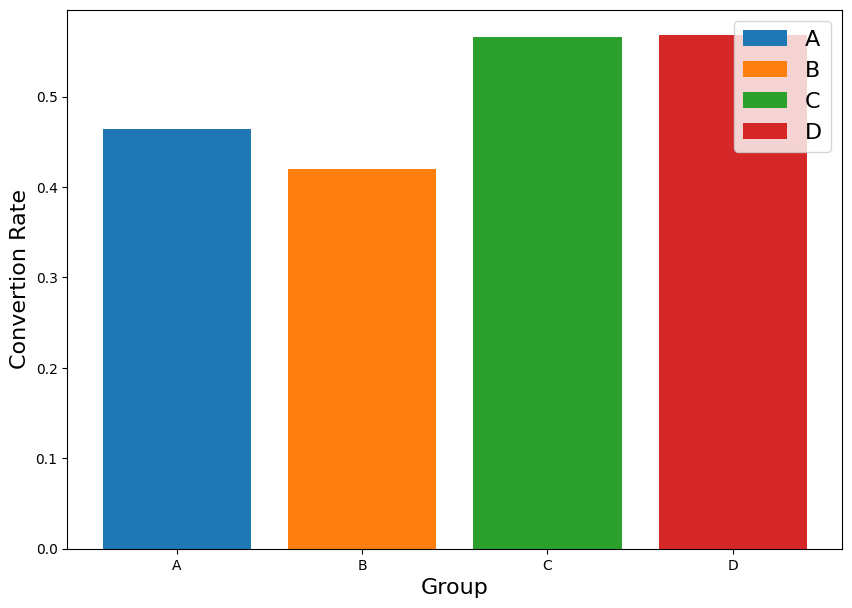

In [160]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

ax.bar("A", cr_A, label="A")
ax.bar("B", cr_B, label="B")
ax.bar("C", cr_C, label="C")
ax.bar("D", cr_D, label="D")

ax.set_ylabel("Convertion Rate", fontsize=16)
ax.set_xlabel("Group", fontsize=16)

plt.legend(fontsize=16)
plt.show();

In [161]:
# Gabung hasil dari experiment AB Testing untuk grup A, B, C, dan D

df_total = pd.concat([data_A,data_B,data_C,data_D])
df_total

,customer_id,OfferId,offer_type,difficulty,reward,duration,channels,groups,conver
7841,50d964e03e2d4b52ba7d8265e3d9f18a,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
5801,3c765494acae43d48f69cc29794dfa1a,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
8451,56ce169a5a5b47e1b2028c663d3a11eb,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
19130,c13cd223575f47ff8fa7f53bd99b5cd8,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
43281,0e1bcbaa5ca64055a1ebc360886b1c17,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,1
...,...,...,...,...,...,...,...,...,...
17915,b4d6477e15ca4b1086638089882177b7,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
7183,4a6b6b268e7b4c6ebf96bc92cd67cf0f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
8605,58a2e3a01a5743d4900d6ad067f515f7,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
47576,54be86b2561e4e379e6446663e4d8935,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1


In [162]:
df_total[['OfferId', 'groups','offer_type','difficulty','reward','duration','channels']].drop_duplicates().sort_values(by='groups')

,OfferId,groups,offer_type,difficulty,reward,duration,channels
7841,ae264e3637204a6fb9bb56bc8210ddfd,A,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']"
11344,4d5c57ea9a6940dd891ad53e9dbe8da0,B,bogo,10.0,10.0,5.0,"['web', 'email', 'mobile', 'social']"
41117,9b98b8c7a33c4b65b9aebfe6a799e6d9,C,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']"
15190,f19421c1d4aa40978ebb69ca19b0e20d,D,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']"


### G.	Mengevaluasi dan Menginterpretasikan Data

- Check apakah ada yang tidak machting antara group dan element yang sudah ditentukan

In [163]:
group_name = "A"
diff = 10.0
reward = 10.0
duration = 7.0
channels = "['email', 'mobile', 'social']"

# Make condition
condition_group = df_total["groups"] == group_name
condition_diff = df_total["difficulty"] == diff
condition_reward = df_total["reward"] == reward
condition_duration = df_total["duration"] == duration
condition_channels = df_total["channels"] == channels


# Select data with the conditions above
data_salah_1 = df_total[condition_group & ~(condition_diff & condition_reward & condition_duration & condition_channels)]
data_salah_1.head()

,customer_id,OfferId,offer_type,difficulty,reward,duration,channels,groups,conver


In [164]:
group_name = "B"
diff = 10.0
reward = 10.0
duration = 5.0
channels = "['web', 'email', 'mobile', 'social']"

# Make condition
condition_group = df_total["groups"] == group_name
condition_diff = df_total["difficulty"] == diff
condition_reward = df_total["reward"] == reward
condition_duration = df_total["duration"] == duration
condition_channels = df_total["channels"] == channels


# Select data with the conditions above
data_salah_2 = df_total[condition_group & ~(condition_diff & condition_reward & condition_duration & condition_channels)]
data_salah_2.head()

,customer_id,OfferId,offer_type,difficulty,reward,duration,channels,groups,conver


In [165]:
group_name = "C"
diff = 5.0
reward = 5.0
duration = 7.0
channels = "['email', 'mobile', 'social']"

# Make condition
condition_group = df_total["groups"] == group_name
condition_diff = df_total["difficulty"] == diff
condition_reward = df_total["reward"] == reward
condition_duration = df_total["duration"] == duration
condition_channels = df_total["channels"] == channels


# Select data with the conditions above
data_salah_3 = df_total[condition_group & ~(condition_diff & condition_reward & condition_duration & condition_channels)]
data_salah_3.head()

,customer_id,OfferId,offer_type,difficulty,reward,duration,channels,groups,conver
41117,7dc62a0a1736432f9a2dbafae8a7687c,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",C,1
20047,cae9515311754366aacb3044f0971484,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",C,0
24802,fd6f5f7b29b247f6af30c9520f355108,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",C,0
41727,a3b25e3ffd2f4a54b6559b7e901e294e,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",C,1
20012,ca85d857e3804e97a4aaf4bd64c75237,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",C,0


In [166]:
group_name = "D"
diff = 5.0
reward = 5.0
duration = 5.0
channels = "['web', 'email', 'mobile', 'social']"

# Make condition
condition_group = df_total["groups"] == group_name
condition_diff = df_total["difficulty"] == diff
condition_reward = df_total["reward"] == reward
condition_duration = df_total["duration"] == duration
condition_channels = df_total["channels"] == channels


# Select data with the conditions above
data_salah_4 = df_total[condition_group & ~(condition_diff & condition_reward & condition_duration & condition_channels)]
data_salah_4.head()

,customer_id,OfferId,offer_type,difficulty,reward,duration,channels,groups,conver


#### Data Exploration

In [167]:
# Percentage in each group
n_total = df_total.shape[0]
persen_A = n_A/n_total * 100 # Control
persen_B = n_B/n_total * 100 # Treatment 1
persen_C = n_C/n_total * 100 # Treatment 2
persen_D = n_D/n_total * 100 # Treatment 3

print(f"% A   : {persen_A:.2f}%")
print(f"% B   : {persen_B:.2f}%")
print(f"% C   : {persen_C:.2f}%")
print(f"% D   : {persen_D:.2f}%")

% A   : 25.00%
% B   : 25.00%
% C   : 25.00%
% D   : 25.00%


Data terbagi dengan jumlah yang sama 

## H. Sample Ratio Mismatch (SRM)

* Sample Ratio Mismatch (SRM) adalah situasi di mana rasio sampel yang diamati dalam eksperimen berbeda dari yang diharapkan.


* **Uji chi-square** dapat digunakan untuk mendeteksi apakah sebuah eksperimen mengalami SRM atau tidak.

Langkah-langkah untuk melakukan uji chi-square dalam rangka mendeteksi SRM adalah:

1. Mendefinisikan hipotesis nol dan alternatif (H0 dan H1).
2. Menghitung statistik chi-square.
3. Menentukan aturan keputusan.
4. Membuat keputusan dan menarik kesimpulan.

#### Chi-Square Test for Detect SRM

**Mengapa Harus Dilakukan :**

1. Memastikan Validitas Eksperimen: SRM membantu mengidentifikasi apakah distribusi sampel sesuai dengan yang diharapkan. Jika terjadi ketidaksesuaian, hasil eksperimen bisa terdistorsi, sehingga mengarah pada kesimpulan yang salah.


2. Mendeteksi Ketidakseimbangan: Dalam eksperimen A/B testing, penting untuk memastikan bahwa proporsi sampel antara grup kontrol dan grup perlakuan sesuai. Uji chi-square memungkinkan kita mendeteksi adanya ketidakseimbangan dalam distribusi sampel.


3. Menilai Keberhasilan Implementasi: Dengan mengidentifikasi SRM, kita dapat mengevaluasi apakah desain dan implementasi eksperimen sudah dilakukan dengan benar, serta apakah semua variabel telah dikendalikan dengan baik.


4. Mengurangi Bias: Menggunakan uji chi-square untuk mendeteksi SRM membantu mengurangi risiko bias dalam analisis data. Ini penting untuk menjaga integritas hasil eksperimen dan untuk pengambilan keputusan yang lebih akurat.


5. Meningkatkan Akurasi: Dengan memastikan bahwa rasio sampel sesuai dengan yang diharapkan, kita dapat lebih percaya diri dalam hasil analisis dan keputusan yang diambil berdasarkan data tersebut.



Secara keseluruhan, melakukan SRM dan uji chi-square adalah langkah penting dalam proses analisis eksperimen untuk memastikan hasil yang valid dan dapat diandalkan.

Langkah-langkah untuk melakukan uji chi-square dalam rangka mendeteksi SRM adalah sebagai berikut:



**1. Mendefinisikan hipotesis nol dan alternatif ($H_0$ dan $H_1$)**

$H_0$ : Tidak terdeteksi adanya SRM

$H_1$ : Terdeteksi adanya SRM

**2. Menghitung statistik chi-square**


$$ \chi^2 = \sum \frac{\left ( \text{observed - expected} \right )^2}{\text{expected}} $$

Di mana:

- Observed adalah jumlah pengguna atau traffic yang diamati di setiap grup. Misalnya, kita memiliki empat grup eksperimen: A, B, C, dan D, dengan jumlah pengguna [n_A, n_B, n_C, n_D].
- Expected adalah jumlah yang diharapkan untuk setiap grup. Karena kita ingin distribusi yang merata (SRM), jumlah total pengguna yang diamati dibagi rata untuk setiap grup. Maka, nilai yang diharapkan untuk setiap grup adalah total_traffic / 4.

Observed sama dengan jumlah pengguna di setiap grup.

Untuk menghitung nilai yang diharapkan pada setiap grup, kita dapat membagi total nilai yang diamati dengan 4.

In [168]:
observed = [ n_A, n_B, n_C, n_D ]
total_traffic= sum(observed)
expected = [ total_traffic/4, total_traffic/4, total_traffic/4, total_traffic/4 ]
expected

[6280.0, 6280.0, 6280.0, 6280.0]

Kemudian kita dapat menghitung statistik chi-square menggunakan fungsi dari pustaka `scipy`, yaitu `chisquare`, dengan langkah-langkah berikut:

1. Mengimpor pustaka:
   - `from scipy.stats import chisquare`
2. Menggunakan fungsi `chisquare(f_obs, f_exp=...)`
   - `f_obs`: Frekuensi yang diamati pada setiap kategori (berbentuk array)
   - `f_exp`: Frekuensi yang diharapkan pada setiap kategori. Secara default, kategori diasumsikan memiliki peluang yang sama.

In [169]:
#calculate chi-square statistics
chi = chisquare(observed, f_exp=expected)
print(chi)

Power_divergenceResult(statistic=0.0, pvalue=1.0)


**3. Define decision rules**

Dalam membuat keputusan uji statistik, kita dapat menggunakan:

- Perbandingan antara statistik chi-square dengan nilai kritis:
     -  $\chi^2 > \chi^2_{\alpha,df}$ → reject $H_0$

- Perbandingan antara nilai p dengan alpha:
   - pvalue < $\alpha$ → reject $H_0$


Biasanya, dalam banyak eksperimen atau uji statistik, tingkat signifikansi (significance level) yang umum digunakan adalah 5% atau 0,05. Artinya, jika nilai p-value dari suatu uji statistik kurang dari 0,05, kita akan menolak hipotesis nol ($H_0$), yang berarti kita menganggap ada perbedaan yang signifikan atau adanya SRM (Sample Ratio Mismatch).

Namun, dalam konteks ini, tingkat signifikansi 5% dianggap tidak cukup ketat. Alasan untuk ini adalah bahwa tingkat signifikansi 0,05 mungkin mengakibatkan lebih banyak sinyal palsu (false positives), yaitu menolak hipotesis nol ketika sebenarnya tidak ada SRM. Dengan kata lain, kita mungkin menganggap bahwa ada masalah dalam eksperimen, padahal sebenarnya tidak ada.

Untuk menghindari sinyal palsu tersebut dan memastikan hasil yang lebih akurat, kita menggunakan tingkat signifikansi yang lebih ketat, yaitu 1% atau 0,01. Dalam hal ini, kita hanya akan menolak hipotesis nol jika p-value lebih kecil dari 0,01. Ini mengurangi risiko sinyal palsu dan memberikan keyakinan lebih besar bahwa jika kita mendeteksi SRM, hasil tersebut lebih dapat dipercaya.

Jadi, penggunaan tingkat signifikansi 1% memastikan bahwa kita hanya menganggap adanya SRM ketika hasilnya benar-benar kuat, sehingga risiko kesalahan dalam mendeteksi SRM lebih kecil.

Derajat kebebasan (df) dihitung sebagai : 
$$ df = (rows − 1) × (columns − 1) $$ 


In [170]:
# Comparison of chi-square statistics with critical value
# We must calculate the critical first

# critical value is the chi-square value at alpha
alpha = 0.01
df=(2-1)*(2-1)  

chi_critical = scipy.stats.chi2.ppf(1 - alpha, df)
print(f"Critical value: {chi_critical:.3f}")

Critical value: 6.635


In [171]:
#Make decisions from chi-square statistics and critical value
if chi[0] > chi_critical:
  print("Reject H0 : SRM may be present.")
else:
  print("Fail to reject H0 : No SRM")

Fail to reject H0 : No SRM


Untuk memutuskan, jika nilai chi-square lebih besar dari nilai kritis (6.635), kita tolak hipotesis nol ($H_0$). Namun, dalam contoh ini, nilai chi-square adalah 0.0, yang lebih kecil dari nilai kritis, sehingga kita gagal menolak hipotesis nol. Artinya, tidak ada SRM yang terdeteksi.

In [172]:
# Comparison of P-Value with alpha.
if chi[1] < 0.01:
    print('Reject H0 : SRM may be present.')
else:
    print('Fail to reject H0 : No SRM.')

Fail to reject H0 : No SRM.


Jika nilai p < alpha (0.01), kita tolak hipotesis nol.
Namun, dalam contoh ini, nilai p adalah 1.0, yang lebih besar dari 0.01, sehingga kita gagal menolak hipotesis nol, dan tidak ada SRM yang terdeteksi.

#### Conclusion
Berdasarkan kualitas data, kami telah melakukan pembersihan data sehingga data yang kami gunakan memiliki kualitas yang cukup baik. Namun, kami perlu memeriksa kembali apakah ukuran sampel setelah pembersihan data sudah memadai (sesuai dengan desain eksperimen) atau belum, agar terdapat kekuatan yang cukup untuk menarik kesimpulan yang kredibel.

Berdasarkan deteksi SRM, SRM tidak terdeteksi.

## I. Hypothesis Testing and Analyzing the Result

In [173]:
def extract_evaluation(data):
    """
    Extract key evaluation criterion within the data
    - number of session
    - number of conversion
    - conversion rate
    :param data: <pandas DataFrame> sample data
    :return results: <dict> contain number of sess., number of conv., & conversion rate
    """
    # Number of session
    n_session = int(data.shape[0])

    # Number of conversion
    n_conversion = int(data["conver"].sum())

    # Conversion rate (in percent)
    conversion_rate = (n_conversion/n_session) * 100

    # Return results
    results = {}
    results["session"] = n_session
    results["conversion"] = n_conversion
    results["CVR"] = np.round(conversion_rate, 2)

    return results


In [174]:
res_A = extract_evaluation(data = data_A)
res_B = extract_evaluation(data = data_B)
res_C = extract_evaluation(data = data_C)
res_D = extract_evaluation(data = data_D)

In [175]:
print(f" A: {res_A}")
print(f" B: {res_B}")
print(f" C: {res_C}")
print(f" D: {res_D}")

 A: {'session': 6280, 'conversion': 2916, 'CVR': 46.43}
 B: {'session': 6280, 'conversion': 2638, 'CVR': 42.01}
 C: {'session': 6280, 'conversion': 3551, 'CVR': 56.54}
 D: {'session': 6280, 'conversion': 3565, 'CVR': 56.77}


#### Calculate lift-over-baseline

$$
\text{Lift} = CVR_{\text{treatment}} - CVR_{\text{control}}
$$

In [176]:
lift_B = res_B["CVR"] - res_A["CVR"]
lift_C = res_C["CVR"] - res_A["CVR"]
lift_D = res_D["CVR"] - res_A["CVR"]

In [177]:
print(f"Lift-overbaseline untuk treatment B adalah {lift_B} %")
print(f"Lift-overbaseline untuk treatment C adalah {lift_C} %")
print(f"Lift-overbaseline untuk treatment D adalah {lift_D} %")

Lift-overbaseline untuk treatment B adalah -4.420000000000002 %
Lift-overbaseline untuk treatment C adalah 10.11 %
Lift-overbaseline untuk treatment D adalah 10.340000000000003 %


####  **Multiple Hypothesis Testing with Benjamini-Hochberg Correction**
---

Pengujian hipotesis berganda dengan Koreksi Benjamini-Hochberg merupakan teknik yang digunakan untuk mengatasi masalah kesalahan Tipe I (false positive) yang meningkat ketika kita melakukan banyak pengujian hipotesis secara simultan. Berikut penjelasan lebih detail:

###### **1. Pengujian Hipotesis**
Saat kita ingin mengetahui mana grup yang memiliki performa terbaik dalam eksperimen (misalnya dalam hal tingkat konversi), kita menggunakan uji hipotesis untuk membandingkan antara dua grup. Salah satu uji yang sesuai untuk kasus ini adalah uji z untuk proporsi, karena kita berfokus pada membandingkan proporsi sukses atau konversi antara dua grup.

###### **2. Uji Hipotesis Berganda**
Jika kita hanya membandingkan dua grup, uji hipotesis yang dilakukan adalah satu kali, sehingga risiko membuat kesalahan Tipe I relatif kecil. Namun, jika kita memiliki lebih dari dua grup, kita perlu melakukan uji hipotesis untuk setiap pasangan grup. Misalnya, jika kita memiliki empat grup (A, B, C, D), kita harus membandingkan:

- A dengan B
- A dengan C
- A dengan D
- B dengan C
- B dengan D
- C dengan D

Semakin banyak pengujian yang kita lakukan, semakin besar risiko kesalahan Tipe I. Kesalahan Tipe I terjadi ketika kita secara tidak sengaja menolak hipotesis nol ($H_0$) dan menganggap ada perbedaan signifikan padahal sebenarnya tidak ada.

###### **3. Masalah dengan Uji Hipotesis Berganda**

Ketika kita melakukan banyak uji hipotesis, risiko terjadinya kesalahan Tipe I (false positive) meningkat. Ini berarti, semakin banyak uji yang kita lakukan, semakin tinggi kemungkinan kita menemukan hasil yang secara keliru dianggap signifikan. Sebagai contoh, dengan tingkat signifikansi 0,05, ada peluang 5% bahwa kita salah menolak hipotesis nol, meskipun sebenarnya benar.

Dalam pengujian hipotesis berganda, tanpa koreksi, kemungkinan besar beberapa hasil uji akan dianggap signifikan secara kebetulan, yang berarti kita mungkin salah mengambil kesimpulan tentang data.

###### **4. Koreksi Benjamini-Hochberg**

Untuk mengatasi masalah ini, kita dapat menggunakan Koreksi Benjamini-Hochberg (BH). Koreksi ini bertujuan untuk mengurangi peluang false positive, tetapi tanpa mengorbankan terlalu banyak kekuatan statistik (kemampuan untuk mendeteksi efek nyata). Berbeda dengan koreksi Bonferroni yang lebih ketat, BH mencoba mempertahankan False Discovery Rate (FDR) — yaitu persentase dari hasil yang signifikan secara statistik yang ternyata palsu.

Langkah-langkah Koreksi Benjamini-Hochberg:
- Urutkan p-value dari pengujian hipotesis yang dilakukan dalam urutan menaik.
- Berikan setiap p-value urutan (rank).
- Hitung nilai ambang dengan rumus:
> $$\text{BH-critical value} = \left ( \frac{i}{m} \right )Q$$

di mana:
   - i adalah urutan (rank) p-value,
   - m adalah jumlah pengujian,
   - α adalah tingkat signifikansi yang kita tetapkan (misalnya, 0.05).

- Bandingkan p-value dengan nilai ambang. Mulai dari p-value terkecil dan naik ke p-value yang lebih besar. Hentikan ketika p-value lebih besar daripada nilai ambang.

Setiap p-value yang lebih kecil dari nilai ambang dianggap signifikan setelah koreksi. Dengan cara ini, kita dapat mengontrol FDR dan mengurangi kemungkinan kesalahan positif tanpa terlalu mengorbankan hasil nyata yang signifikan.

**Berikut adalah tahapan untuk melakukan analisis:**

##### 1. Define null hypothesis ($H_0$) and alternative hypothesis ($H_1$)

The hypothesis for each group pair is as follows:
- group A vs group B
    $$H_0 : p_B \leq p_A$$
    $$H_1 : p_B > p_A$$

- group A vs group C
    $$H_0 : p_C \leq p_A$$
    $$H_1 : p_C > p_A$$

- group A vs group D
    $$H_0 : p_D \leq p_A$$
    $$H_1 : p_D > p_A$$

- group B vs group C
    $$H_0 : p_C \leq p_B$$
    $$H_1 : p_C > p_B$$

- group B vs group D
    $$H_0 : p_D \leq p_B$$
    $$H_1 : p_D > p_B$$

- group C vs group D
    $$H_0 : p_D \leq p_C$$
    $$H_1 : p_D > p_C$$

- Set siginificance level (alpha)
- Significance level = 0.05

##### 2. Calculate the p-value in each test

Kode di atas digunakan untuk menghitung p-value dari uji hipotesis perbandingan dua proporsi, dalam hal ini membandingkan konversi dari grup A dan grup B. P-value yang dihasilkan dapat digunakan untuk memutuskan apakah terdapat perbedaan signifikan antara konversi di dua grup tersebut. Mari kita jelaskan secara rinci:

1. Menggunakan Uji Proporsi (Z-Test)
Fungsi proportions_ztest dari pustaka statsmodels digunakan untuk melakukan uji z untuk proporsi, yang membantu dalam mengevaluasi apakah terdapat perbedaan signifikan antara dua proporsi konversi dari dua grup (A dan B).

2. Argumen count = [n_convertB, n_convertA]
Ini merepresentasikan jumlah konversi yang terjadi pada grup B dan grup A:

n_convertB: Jumlah pengguna di grup B yang melakukan konversi.
n_convertA: Jumlah pengguna di grup A yang melakukan konversi.
Data ini mewakili hasil nyata (observasi) dari eksperimen.

3. Argumen nobs = [n_B, n_A]
Argumen ini menunjukkan total jumlah pengguna yang diuji di masing-masing grup:

n_B: Total pengguna atau sampel di grup B.
n_A: Total pengguna atau sampel di grup A.
Ini adalah ukuran sampel masing-masing grup.

4. Argumen alternative = 'larger'
Argumen ini menyatakan hipotesis alternatif. Dalam hal ini, 'larger' mengindikasikan bahwa kita sedang menguji apakah proporsi konversi di grup A lebih kecil daripada grup B atau sebaliknya (B > A).

Jika hasilnya mendukung hipotesis alternatif, ini berarti proporsi konversi di grup B lebih tinggi dibandingkan A.
5. Mengambil P-value
Bagian [1] setelah fungsi proportions_ztest mengacu pada p-value yang dihasilkan dari uji proporsi ini. Uji proporsi menghasilkan dua nilai, yaitu z-statistic dan p-value, di mana kita hanya tertarik pada p-value (nilai probabilitas).

6. P-value dan Pengambilan Keputusan
P-value yang dihasilkan akan digunakan untuk menentukan apakah kita dapat menolak hipotesis nol (H₀: Tidak ada perbedaan antara grup A dan B).
Jika p-value lebih kecil dari tingkat signifikansi (biasanya 0.05 atau 0.01), kita dapat menolak H₀ dan menyimpulkan bahwa ada perbedaan signifikan antara proporsi konversi grup A dan B.

In [178]:
# call function
#p-value group A vs group B hypotesis test
p_value_AB = proportions_ztest(count = [n_convertB, n_convertA],
                               nobs = [n_B, n_A],
                               alternative = 'larger')[1]

print(f"P-value A vs B: {p_value_AB:.4f}") # 1.123109e-167	

P-value A vs B: 1.0000


Dalam pengujian yang di lakukan dengan menggunakan uji proporsi (proportions z-test) antara grup B dan grup A, hasil yang ditemukan adalah:

B > A: Ini menunjukkan bahwa proporsi konversi di grup B lebih tinggi daripada di grup A.
p-value = 1.123109e-167: Ini adalah nilai probabilitas yang dihasilkan dari pengujian. Nilai p-value ini sangat kecil, jauh di bawah batas umum 0.05 atau bahkan 0.01.

Apa Artinya?

1. Pengujian Hipotesis:

    * Hipotesis nol (H₀) biasanya menyatakan bahwa tidak ada perbedaan antara proporsi konversi di grup B dan grup A. Dalam hal ini, H₀ adalah bahwa proporsi konversi di B tidak lebih tinggi dari di A.
    * Hipotesis alternatif (H₁) menyatakan bahwa proporsi konversi di grup B lebih tinggi daripada di grup A.
    

2. Interpretasi p-value:

    * Nilai p-value yang sangat kecil (1.123109e-167) menunjukkan bahwa ada bukti yang sangat kuat untuk menolak hipotesis nol.
    * Ini berarti bahwa proporsi konversi di grup B secara signifikan lebih tinggi daripada di grup A.
    

3. Keputusan:

    * Karena p-value ini jauh lebih kecil dari tingkat signifikansi yang umum digunakan (misalnya, 0.05 atau 0.01), Anda dapat menyimpulkan bahwa ada perbedaan yang signifikan dalam konversi antara grup B dan grup A, dengan grup B memiliki proporsi konversi yang lebih tinggi.

**Kesimpulan:**
Dengan kata lain, berdasarkan hasil uji ini, Anda dapat berargumen bahwa strategi atau elemen yang diterapkan di grup B lebih efektif dalam menghasilkan konversi dibandingkan dengan grup A.

In [179]:
#p-value group A vs group C hypotesis test
p_value_AC = proportions_ztest(count = [n_convertC, n_convertA],
                               nobs = [n_C, n_A],
                               alternative = 'larger')[1]

print(f"P-value A vs C: {p_value_AC:.4f}")

P-value A vs C: 0.0000


In [180]:
#p-value group A vs group D hypotesis test
p_value_AD = proportions_ztest(count = [n_convertD, n_convertA],
                               nobs = [n_D, n_A],
                               alternative = 'larger')[1]

print(f"P-value A vs D: {p_value_AD:.4f}")

P-value A vs D: 0.0000


In [181]:
#p-value group B vs group C hypotesis test
p_value_BC = proportions_ztest(count = [n_convertC, n_convertB],
                               nobs = [n_C, n_B],
                               alternative = 'larger')[1]

print(f"P-value B vs C: {p_value_BC:.4f}")

P-value B vs C: 0.0000


In [182]:
#p-value group B vs group D hypotesis test
p_value_BD = proportions_ztest(count = [n_convertD, n_convertB],
                               nobs = [n_D, n_B],
                               alternative = 'larger')[1]

print(f"P-value B vs D: {p_value_BD:.4f}")

P-value B vs D: 0.0000


In [183]:
#p-value group C vs group D hypotesis test
p_value_CD = proportions_ztest(count = [n_convertD, n_convertC],
                               nobs = [n_D, n_C],
                               alternative = 'larger')[1]

print(f"P-value C vs D: {p_value_CD:.4f}")

P-value C vs D: 0.4005


In [184]:
# make dataframe consist of p-values
pair_group = ['B > A',
              'C > A',
              'D > A',
              'C > B',
              'D > B',
              'D > C']

p_vals = [p_value_AB, p_value_AC,
          p_value_AD, p_value_BC,
          p_value_BD, p_value_CD]

df_p_vals = pd.DataFrame({'pair_group': pair_group,
                          'p-value': p_vals})

#print
df_p_vals_order = df_p_vals.sort_values(by=['p-value'])

##### Assign ranks to the ordered p-values.

In [185]:
df_p_vals_order['rank'] = df_p_vals_order['p-value'].rank().sub(0).astype(int)
df_p_vals_order

,pair_group,p-value,rank
4,D > B,8.804601e-62,1
3,C > B,5.364431e-60,2
2,D > A,2.374838e-31,3
1,C > A,4.297854e-30,4
5,D > C,4.004879e-01,5
0,B > A,9.999997e-01,6


Using the formula :

$$\text{BH-critical value} = \left ( \frac{i}{m} \right )Q$$


where:
- $i$ = the p-value’s rank
- $m$ = total number of tests
- $Q$ = the false discovery rate (chosen by the experimenter)

- Suppose that, the experimenter want to control false discoverry rate in 5%. So the $Q=0.05$

In [186]:
#define Q
Q = 0.05

#calculate BH-critical value
df_p_vals_order['BH-crit'] = df_p_vals_order['rank']/len(df_p_vals_order)*Q

#print
df_p_vals_order

,pair_group,p-value,rank,BH-crit
4,D > B,8.804601e-62,1,0.008333
3,C > B,5.364431e-60,2,0.016667
2,D > A,2.374838e-31,3,0.025000
1,C > A,4.297854e-30,4,0.033333
5,D > C,4.004879e-01,5,0.041667
0,B > A,9.999997e-01,6,0.050000


##### Compare original p-values to the Benjamini-Hochberg critical value 

If the original p-values smaller than Benjamini-Hochberg critical, then the test are significant (reject $H_0$)


In [187]:
# make new column with condition
df_p_vals_order['Significant?'] = np.where(df_p_vals_order['p-value'] < df_p_vals_order['BH-crit'],
                                           'Yes',
                                           'No')

#print
df_p_vals_order

,pair_group,p-value,rank,BH-crit,Significant?
4,D > B,8.804601e-62,1,0.008333,Yes
3,C > B,5.364431e-60,2,0.016667,Yes
2,D > A,2.374838e-31,3,0.025000,Yes
1,C > A,4.297854e-30,4,0.033333,Yes
5,D > C,4.004879e-01,5,0.041667,No
0,B > A,9.999997e-01,6,0.050000,No


Kolom-kolom dalam Hasil:

1. pair_group:

> Ini menunjukkan perbandingan antara grup yang diuji. Misalnya, "D > B" berarti membandingkan konversi grup C dengan grup A.

2. p-value:

>Ini adalah nilai probabilitas yang dihasilkan dari uji hipotesis untuk masing-masing perbandingan. P-value yang sangat kecil menunjukkan bahwa ada perbedaan yang signifikan antara dua grup.
Contoh:
Untuk perbandingan D dan B, p-value sangat kecil (8.804601e-62), menunjukkan bahwa konversi grup D jauh lebih tinggi dibandingkan grup B.

3. rank:

>Ini menunjukkan urutan p-value dari yang terkecil ke yang terbesar. Semakin kecil p-value, semakin tinggi peringkatnya. Dalam konteks ini, ini mencerminkan urutan kekuatan bukti untuk perbandingan konversi.
Contoh:
"D > B" mendapat peringkat 1, yang berarti ini adalah perbandingan paling signifikan.

4. BH-crit:

>Ini adalah nilai kritis yang ditentukan oleh metode Benjamini-Hochberg, yang digunakan untuk menentukan batas p-value yang dapat diterima untuk menghindari kesalahan Tipe I.
Nilai ini dihitung berdasarkan peringkat p-value dan jumlah total uji yang dilakukan. Semakin tinggi peringkat, semakin besar nilai BH-crit.
Dalam contoh Anda, jika p-value lebih kecil dari BH-crit, kita menolak hipotesis nol.

##### **Interpretasi Hasil:**
1. D > B (p-value: 8.804601e-62):

- Rank 1, BH-crit: 0.008333, Significant: Yes
- P-value yang sangat kecil, jauh di bawah batas BH-crit. Ini berarti kita menolak hipotesis nol (H₀) dan menyimpulkan bahwa konversi di grup D jauh lebih tinggi dibandingkan dengan grup B.

2. C > B (p-value: 5.364431e-60):

- Rank 2, BH-crit: 0.016667, Significant: Yes
- P-value juga sangat kecil, jauh di bawah BH-crit. Ini menunjukkan bahwa konversi grup C lebih tinggi dibandingkan dengan grup B, dan kita menolak H₀.

3. D > A (p-value: 2.374838e-31):

- Rank 3, BH-crit: 0.025000, Significant: Yes
- P-value jauh di bawah BH-crit, sehingga kita menolak H₀. Konversi di grup D lebih tinggi dibandingkan grup A.

4. C > A (p-value: 4.297854e-30):

- Rank 4, BH-crit: 0.033333, Significant: Yes
- P-value sangat kecil, kita menolak H₀, dan dapat disimpulkan bahwa konversi di grup C lebih tinggi dibandingkan dengan grup A.

5. D > C (p-value: 0.400488):

- Rank 5, BH-crit: 0.041667, Significant: No
- P-value lebih besar dari BH-crit, sehingga kita gagal menolak H₀. Tidak ada bukti yang cukup untuk menyimpulkan bahwa konversi grup D lebih tinggi dibandingkan grup C.

6. B > A (p-value: 0.9999997):

- Rank 6, BH-crit: 0.050000, Significant: No
- P-value sangat besar, jauh di atas BH-crit. Ini menunjukkan bahwa kita gagal menolak H₀, dan tidak ada cukup bukti untuk menyatakan bahwa konversi grup B lebih tinggi dibandingkan grup A.

**Conclusion**

- Grup D memiliki performa konversi terbaik, unggul secara signifikan dibandingkan dengan grup B dan A.
- Grup C juga memiliki performa yang lebih baik dibandingkan dengan grup A dan B, tetapi tidak lebih baik dari grup D.
- Tidak ada bukti yang cukup bahwa Grup B memiliki konversi lebih tinggi daripada grup A atau bahwa grup D lebih baik daripada grup C.

1. Grup D
2. Grup C
3. Grup B
4. Grup A

        WHEN [OfferId] ='ae264e3637204a6fb9bb56bc8210ddfd' THEN 'A'
        WHEN [OfferId] = '4d5c57ea9a6940dd891ad53e9dbe8da0' THEN 'B'
        WHEN [OfferId] = '9b98b8c7a33c4b65b9aebfe6a799e6d9'THEN 'C'
        WHEN [OfferId] = 'f19421c1d4aa40978ebb69ca19b0e20d' THEN 'D'

In [197]:
query2 = ''' 
SELECT 
    left(OfferId, 4) as offerid,
    CASE
        WHEN [OfferId] = 'ae264e3637204a6fb9bb56bc8210ddfd' THEN 'A'
        WHEN [OfferId] = '4d5c57ea9a6940dd891ad53e9dbe8da0' THEN 'B'
        WHEN [OfferId] = '9b98b8c7a33c4b65b9aebfe6a799e6d9' THEN 'C'
        WHEN [OfferId] = 'f19421c1d4aa40978ebb69ca19b0e20d' THEN 'D'
    END AS GROUPS,
    SUM(CAST(reward_get AS float)) AS Reward_Give,
    SUM(CAST(Amount AS float)) AS Total_Amount,
    SUM(CAST(Amount AS float)) - SUM(CAST(reward_get AS float)) AS ranges
FROM [ads].[dbo].[new_data]
WHERE offer_type = 'bogo'
GROUP BY OfferId,
    CASE
        WHEN [OfferId] = 'ae264e3637204a6fb9bb56bc8210ddfd' THEN 'A'
        WHEN [OfferId] = '4d5c57ea9a6940dd891ad53e9dbe8da0' THEN 'B'
        WHEN [OfferId] = '9b98b8c7a33c4b65b9aebfe6a799e6d9' THEN 'C'
        WHEN [OfferId] = 'f19421c1d4aa40978ebb69ca19b0e20d' THEN 'D'
    END;

  '''

In [198]:
# Eksekusi query menggunakan pandas
df3 = pd.read_sql(query2, engine)
df3

,offerid,GROUPS,Reward_Give,Total_Amount,ranges
0,ae26,A,36350.0,76727.28,40377.28
1,4d5c,B,33010.0,69963.98,36953.98
2,9b98,C,21515.0,68038.25,46523.25
3,f194,D,21310.0,73341.68,52031.68


1. Grup D (Offer ID: f194):

Grup D adalah yang terbaik dalam hal performa konversi, terutama dalam menghasilkan margin terbesar. Dengan Reward Give sebesar 21.310 dan Total Amount sebesar 73.341,68, grup ini menunjukkan efisiensi tinggi dalam hal reward yang diberikan dan total nilai transaksi. Range sebesar 52.031,68 adalah yang tertinggi, menunjukkan kemampuan Grup D dalam memberikan hasil konversi terbaik dengan alokasi reward yang efisien.

2. Grup C (Offer ID: 9b98):

Grup C menempati posisi kedua dalam performa konversi. Meskipun reward yang diberikan lebih kecil (21.515), Grup C berhasil mencapai Total Amount sebesar 68.038,25 dan range sebesar 46.523,25. Ini menunjukkan bahwa Grup C sangat efisien dalam menghasilkan nilai transaksi yang baik dengan reward yang lebih rendah dibandingkan Grup D.

3. Grup A (Offer ID: ae26):

Grup A berada di posisi ketiga, dengan Reward Give yang tertinggi yaitu 36.350 dan Total Amount sebesar 76.727,28. Meskipun jumlah reward yang diberikan sangat besar, range sebesar 40.377,28 lebih rendah dibandingkan Grup D dan C, menandakan bahwa Grup A memiliki efisiensi yang lebih rendah dalam mengkonversi reward menjadi transaksi.

4. Grup B (Offer ID: 4d5c):

Grup B menunjukkan performa terendah dalam konversi dengan Reward Give sebesar 33.010 dan Total Amount sebesar 69.963,98. Dengan range terendah sebesar 36.953,98, Grup B terlihat kurang efisien dalam menghasilkan transaksi dibandingkan grup lainnya, meskipun memberikan reward yang cukup besar.

#### Kesimpulan 

* Grup D adalah yang terbaik dalam hal efisiensi konversi reward menjadi transaksi.
* Grup C menempati posisi kedua dengan performa konversi yang solid meskipun dengan reward lebih rendah.
* Grup A memberikan reward yang besar, namun efisiensinya lebih rendah dalam menghasilkan transaksi.
* Grup B memiliki performa terendah dalam konversi dan range terkecil, menjadikannya pilihan paling tidak efektif.

#### confidence interval dari perbedaan antara group

*   Untuk menghitung confidence interval for proportion, kita dapat menggunakan [statsmodels.stats.proportion.confint_proportions_2indep](https://https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.confint_proportions_2indep.html)



In [190]:
confidence_interval_AB = confint_proportions_2indep(count1 = n_convertB, nobs1 = n_B,
                                                 count2 = n_convertA, nobs2 = n_A, 
                                                 compare='diff', alpha=0.05)
print(f"Difference A vs B: {confidence_interval_AB}")

Difference A vs B: (-0.06159750261643404, -0.026899777909596117)


In [191]:
confidence_interval_AC = confint_proportions_2indep(count1 = n_convertC, nobs1 = n_C,
                                                 count2 = n_convertA, nobs2 = n_A, 
                                                 compare='diff', alpha=0.05)
print(f"Difference A vs C: {confidence_interval_AC}")

Difference A vs C: (0.08368513114807757, 0.1184568291438987)


In [192]:
confidence_interval_AD = confint_proportions_2indep(count1 = n_convertD, nobs1 = n_D,
                                                 count2 = n_convertA, nobs2 = n_A, 
                                                 compare='diff', alpha=0.05)
print(f"Difference A vs D: {confidence_interval_AD}")

Difference A vs D: (0.08591868831249476, 0.12067995770193314)


In [193]:
confidence_interval_BC = confint_proportions_2indep(count1 = n_convertC, nobs1 = n_C,
                                                 count2 = n_convertB, nobs2 = n_B, 
                                                 compare='diff', alpha=0.05)
print(f"Difference B vs C: {confidence_interval_BC}")

Difference B vs C: (0.12802364015214523, 0.16261502935871716)


In [194]:
confidence_interval_BD = confint_proportions_2indep(count1 = n_convertD, nobs1 = n_D,
                                                 count2 = n_convertB, nobs2 = n_B, 
                                                 compare='diff', alpha=0.05)
print(f"Difference B vs D: {confidence_interval_BD}")

Difference B vs D: (0.13025721473444443, 0.16483811875852816)


In [195]:
confidence_interval_CD = confint_proportions_2indep(count1 = n_convertD, nobs1 = n_D,
                                                 count2 = n_convertC, nobs2 = n_C, 
                                                 compare='diff', alpha=0.05)
print(f"Difference C vs D: {confidence_interval_CD}")

Difference C vs D: (-0.015099372425550504, 0.019556078589053533)


In [196]:
confidence_interval_AB = list(confidence_interval_AB)
confidence_interval_AC = list(confidence_interval_AC)
confidence_interval_AD = list(confidence_interval_AD)
confidence_interval_BC = list(confidence_interval_BC)
confidence_interval_BD = list(confidence_interval_BD)
confidence_interval_CD = list(confidence_interval_CD)

index = ['confidence_interval_AB','confidence_interval_AC','confidence_interval_AD','confidence_interval_BC',
         'confidence_interval_BD','confidence_interval_CD']

confidence_interval = [confidence_interval_AB, confidence_interval_AC, confidence_interval_AD,
                      confidence_interval_BC, confidence_interval_BD, confidence_interval_CD]

df_ci = pd.DataFrame(confidence_interval, columns = ["lower","upper"])
df_ci = df_ci.set_index([index])
df_ci

,lower,upper
confidence_interval_AB,-0.061598,-0.026900
confidence_interval_AC,0.083685,0.118457
confidence_interval_AD,0.085919,0.120680
confidence_interval_BC,0.128024,0.162615
confidence_interval_BD,0.130257,0.164838
confidence_interval_CD,-0.015099,0.019556


**confidence interval (CI)** digunakan untuk memperkirakan rentang perbedaan proporsi konversi antara dua grup secara statistik. Interval ini menunjukkan sejauh mana kita bisa yakin bahwa perbedaan antara dua proporsi konversi sebenarnya berada dalam rentang tertentu, dengan tingkat kepercayaan (confidence level) sebesar 95%.

Mari kita bahas interpretasi dari setiap pasangan grup berdasarkan hasil confidence interval:

1. confidence_interval_AB (B vs A):

- Lower bound: -0.061598
- Upper bound: -0.026900

Artinya, Interval ini berada di bawah nol, yang berarti bahwa grup A memiliki proporsi konversi yang lebih rendah dibandingkan grup B. Tidak ada kemungkinan bahwa grup A lebih baik dari grup B dalam hal konversi.

2. confidence_interval_AC (C vs A):

- Lower bound: 0.083685
- Upper bound: 0.118457

Interval ini seluruhnya di atas nol, yang berarti bahwa grup C memiliki proporsi konversi yang lebih tinggi daripada grup A. Perbedaan signifikan ini mendukung bahwa grup C lebih baik dalam hal konversi dibandingkan A.

3. confidence_interval_AD (D vs A):

- Lower bound: 0.085919
- Upper bound: 0.120680

Sama seperti A vs C, interval ini juga di atas nol, menunjukkan bahwa grup D memiliki proporsi konversi yang lebih tinggi daripada grup A

4. confidence_interval_BC (C vs B):

- Lower bound: 0.128024
- Upper bound: 0.162615

Interval ini menunjukkan bahwa grup C memiliki proporsi konversi yang lebih tinggi dibandingkan grup B. Grup C secara signifikan lebih unggul dalam hal konversi dibandingkan grup B.

5. confidence_interval_BD (D vs B):

- Lower bound: 0.130257
- Upper bound: 0.164838

Sama seperti B vs C, interval ini menunjukkan bahwa grup D memiliki proporsi konversi yang lebih tinggi dibandingkan grup B.

6. confidence_interval_CD (C vs D):

- Lower bound: -0.015099
- Upper bound: 0.019556

Interval ini mengandung nol, yang berarti tidak ada perbedaan yang signifikan antara proporsi konversi grup C dan grup D. Kedua grup ini memiliki kinerja konversi yang kurang lebih sama.

**Kesimpulan dari hasil confidence interval ini:**

- Grup C dan D secara signifikan lebih baik dalam konversi dibandingkan dengan grup A dan B.
- Tidak ada perbedaan signifikan antara C dan D, artinya mereka memiliki performa konversi yang hampir setara.
- Grup B lebih baik dari Grup A, tetapi masih kalah dari grup C dan D.

Confidence interval ini mendukung kesimpulan sebelumnya bahwa Grup C dan D adalah yang terbaik, diikuti oleh Grup A, dengan Grup B 

**semua hal diatas dikerjakan dengan mengimplementasikan apa yang saya pelajari melalui pacmannn** 👍💗
**dan jika ada kesalahan dalam pengerjaan bukan lah salah pacmann namun itu kesalahan saya yang kurang dalam memahami maksud dan tujuan dari tiap perintah baris code, maka dari itu jika ada yang salah tolong koreksi 😊**

**untuk SQL saya sendiri yang mengerjakan sedangkan yang python banyak bantuan AI dalam pengerjaanya dan code yang dishare pacmann dari tiap live classnya**